# Coherence-Enhancing Diffusion with Optimized Rotation Invariance
## Proof of concept
**DOI**:  [Weickert 2022](https://doi.org/10.1006/jvci.2001.0495)

To observe how the CED inspired algorithm works, we test on a vector field from the dmri data, and an image containing a square in the middle.

In [1]:
import numpy as np
from scipy.signal import convolve2d

from pyfusion import plotting, loading

In [2]:
# All the constants

# Data
DIRNAME = "../../data/example_mri"
SCLICE = 70
WINDOW_X = 45
WINDOW_Y = 105
SQ_SIZE = 10

# Preprocessing
KERNEL_SIZE = 3
NOISE_SCALE = 0.2   # sigma
INTEGRATION_SCALE = 10   # rho
ALPHA = 0.001
ATOL = 1e-1

# Algorithm
ITERATIONS = 1000
STEP_SIZE = 1

# function for later use
def lambda_func(mu_1, mu_2):    # type: ignore
    """
    Compute the second eigenvalue based on the first eigenvalue and the second mean, if mu_1 and mu_2 are not close.
    """
    return ALPHA + (1-ALPHA) * np.exp(-1/(mu_1 - mu_2)**2)  # type: ignore

In [3]:
# Load the data
FSL = loading.load_fsl(DIRNAME, SCLICE)

In [4]:
N = WINDOW_Y - WINDOW_X

original_image = np.zeros((N, N), dtype=np.float32)

# make a square in the middle
original_image[N//2 - SQ_SIZE//2:N//2 + SQ_SIZE//2, N//2 - SQ_SIZE//2:N//2 + SQ_SIZE//2] = 1.0

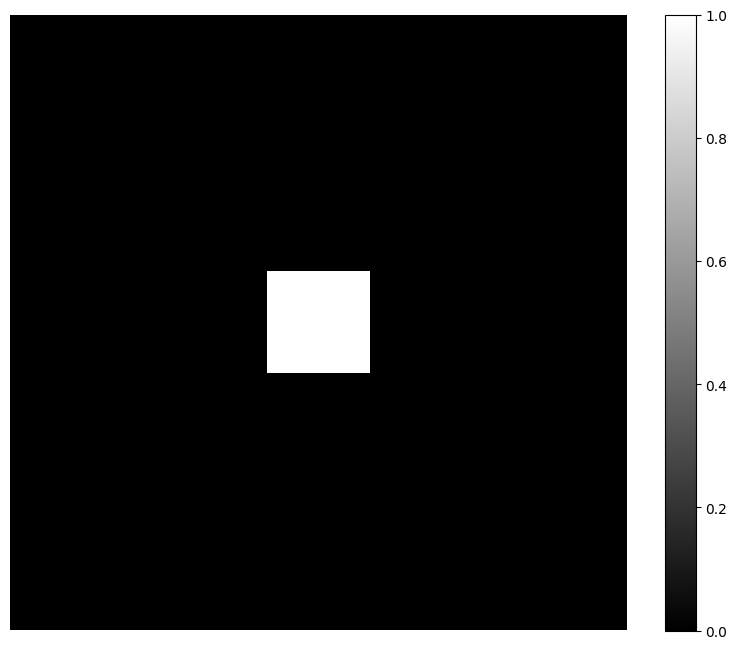

In [5]:
plotting.plot(original_image)

In [6]:
eigvec_1, eig_val_1 = FSL.V1[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y, :], FSL.L1[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y]
eigvec_2, eig_val_2 = FSL.V2[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y, :], FSL.L2[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y]
eigvec_3, eig_val_3 = FSL.V3[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y, :], FSL.L3[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y]

V = np.stack([eigvec_1, eigvec_2, eigvec_3], axis=-1)  # type: ignore

Lambda = np.stack([eig_val_1, eig_val_2, eig_val_3], axis=-1)  # type: ignore

V_scaled = V * Lambda[..., np.newaxis, :]  # type: ignore

tensor_field = np.matmul(V_scaled, np.swapaxes(V, -1, -2))  # type: ignore
tensor_field = tensor_field[..., :2, :2]  # type: ignore

In [7]:
eigval, eigvec = np.linalg.eig(tensor_field)  # type: ignore

idx = np.argsort(eigval, axis=-1)[..., ::-1]  # (n,m,2)

n, m, _, _ = tensor_field.shape
i, j = np.meshgrid(np.arange(n), np.arange(m), indexing="ij")  # type: ignore

eigval = np.take_along_axis(eigval, idx, axis=-1)
eigvec = np.take_along_axis(
    eigvec,
    idx[..., None, :],  # (n,m,1,2) to broadcast correctly
    axis=-1,
)

In [8]:
# for numerical stability
eigval[..., 0] = 1000 * eigval[..., 0]
eigval[..., 1] = 1000 * eigval[..., 1]

For the documentation of the above code, see [this](ced_dmri.ipynb) notebook. So first we can plot the first eigenvector, scaled by their eigenvalue. Thats the direction the CED should diffuse

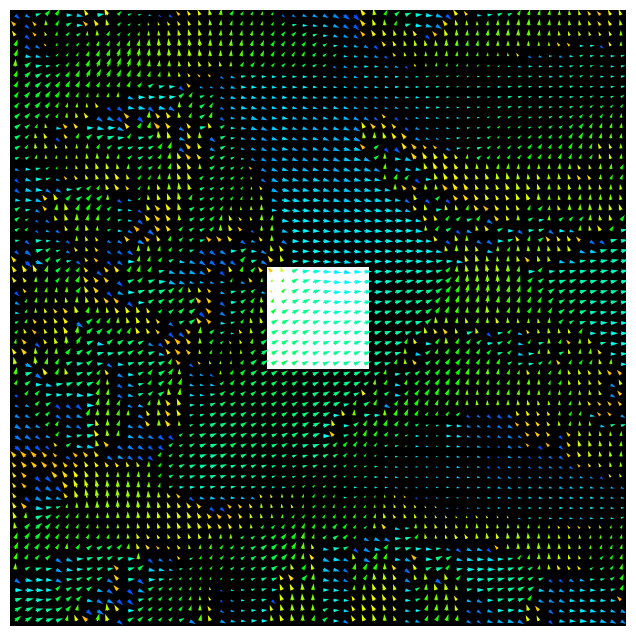

In [9]:
scaled_eig_1 = eigval[..., 0, np.newaxis] * eigvec[..., :, 0]

plotting.plot_with_vector_field(original_image, scaled_eig_1)

In [10]:
alpha_1 = np.arctan2(eigvec[..., 1, 0], eigvec[..., 0, 0])  # type: ignore

lambda_2 = ALPHA
lambda_1 = np.zeros_like(eigval[..., 0])  # type: ignore
mask = np.isclose(eigval[..., 0], eigval[..., 1], atol=ATOL)  # type: ignore
lambda_1[mask] = ALPHA
lambda_1[~mask] = lambda_func(eigval[..., 0][~mask], eigval[..., 1][~mask])  # type: ignore

In [11]:
a = lambda_1 * np.cos(alpha_1) ** 2 + lambda_2 * np.sin(alpha_1) ** 2
b = (lambda_1 - lambda_2) * np.cos(alpha_1) * np.sin(alpha_1)
c = lambda_1 * np.sin(alpha_1) ** 2 + lambda_2 * np.cos(alpha_1) ** 2

In [12]:
D_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]) / 32
D_y = np.array([[3, 10, 3], [0, 0, 0], [-3, -10, 3]]) / 32

In [13]:
img = original_image.copy()

for _ in range(ITERATIONS):
    j_1 = a * convolve2d(img, D_x, mode="same", boundary="symm") + b * convolve2d(
        img, D_y, mode="same", boundary="symm"
    )  # type: ignore
    j_2 = b * convolve2d(img, D_x, mode="same", boundary="symm") + c * convolve2d(
        img, D_y, mode="same", boundary="symm"
    )  # type: ignore

    delta = convolve2d(j_1, D_x, mode="same", boundary="symm") + convolve2d(j_2, D_y, mode="same", boundary="symm")  # type: ignore

    img += STEP_SIZE * delta

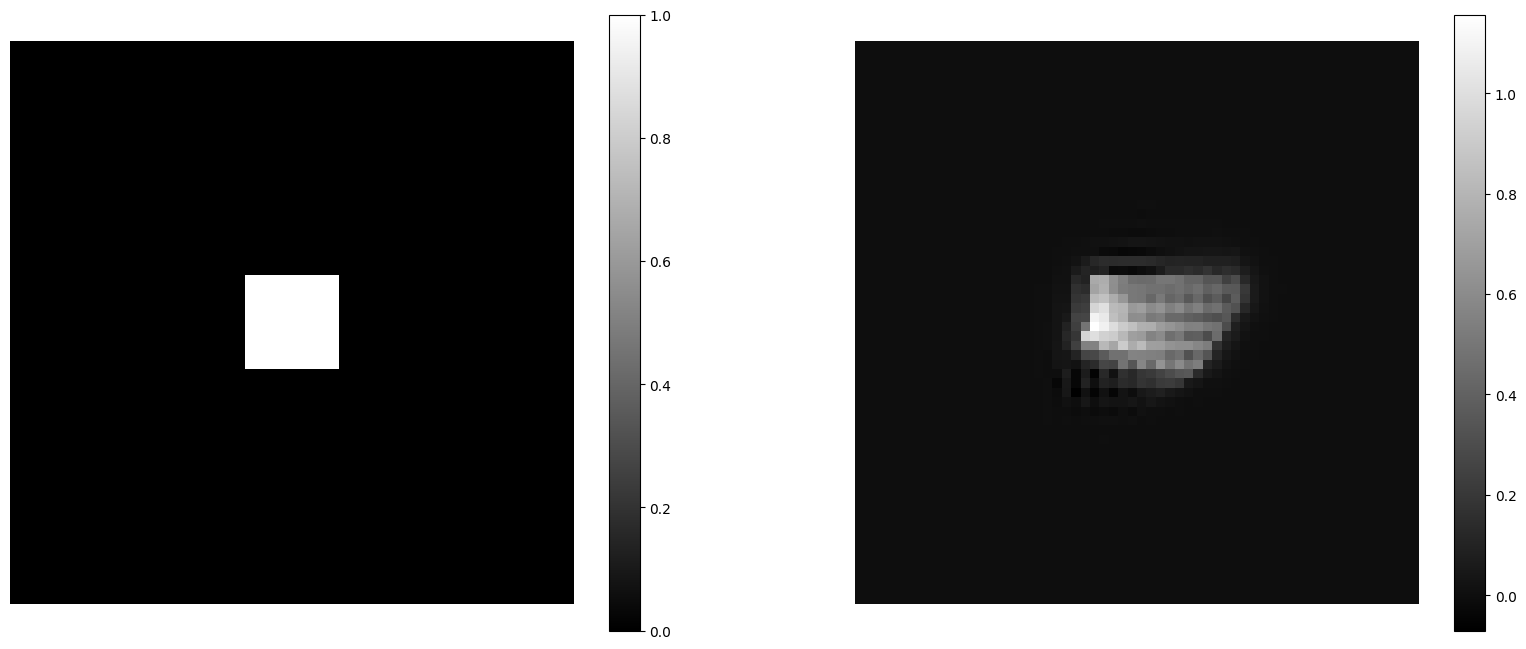

In [14]:
plotting.plot_side_by_side(original_image, img)

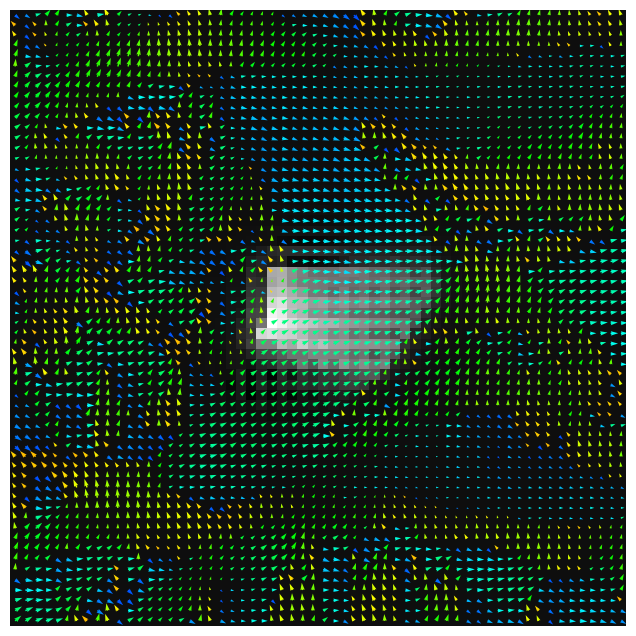

In [15]:
plotting.plot_with_vector_field(img, scaled_eig_1)